In [1]:
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms

In [2]:
label = pd.read_csv('RSNA/labels_1.csv')
label = label[['Image','any']]
dir_data = 'RSNA/folder_1/'

In [3]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.labels = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0] + '.png')

        
        image = Image.open(img_name)
        label = int(self.labels.iloc[idx, 1])

        if self.transform:
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label
# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.Rotate(limit=20),  # Random rotation between -20 and 20 degrees
        albu.GaussianBlur(p=0.3),
        albu.HueSaturationValue(p=0.3),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'test': albu.Compose([   # Generally, you don't augment test data. Just resize and normalize.
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Split the DataFrame into training, validation, and test sets
train_data, temp_data = train_test_split(label, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


# Create the dataset and dataloader
# Assuming `dir_data` is your root directory for the images
train_dataset = CustomDataset(dataframe=train_data, root_dir=dir_data, transform=data_transforms['train'])
val_dataset = CustomDataset(dataframe=val_data, root_dir=dir_data, transform=data_transforms['val'])
test_dataset = CustomDataset(dataframe=test_data, root_dir=dir_data, transform=data_transforms['test'])


dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'valid': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of train images: 57695
Number of validation images: 12363
Number of test images: 12364


In [12]:
from collections import Counter

def label_distribution(dataset):
    return Counter(dataset.labels.iloc[:, 1])

train_label_dist = label_distribution(train_dataset)
val_label_dist = label_distribution(val_dataset)
test_label_dist = label_distribution(test_dataset)

print("Train Label Distribution:")
for label, count in train_label_dist.items():
    print(f"Label {label}: {count} images")

print("\nValidation Label Distribution:")
for label, count in val_label_dist.items():
    print(f"Label {label}: {count} images")

print("\nTest Label Distribution:")
for label, count in test_label_dist.items():
    print(f"Label {label}: {count} images")


Train Label Distribution:
Label 1: 11388 images
Label 0: 46307 images

Validation Label Distribution:
Label 0: 9958 images
Label 1: 2405 images

Test Label Distribution:
Label 0: 9885 images
Label 1: 2479 images


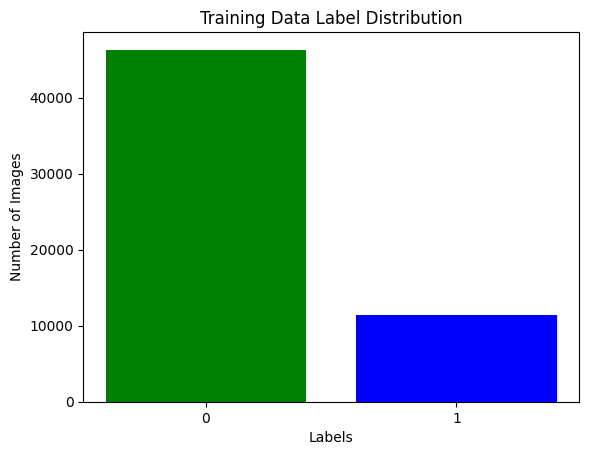

In [14]:
import matplotlib.pyplot as plt

def plot_label_distribution(dist, title):
    labels = list(dist.keys())
    counts = list(dist.values())
    
    plt.bar(labels, counts, color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])  # Colors can be modified
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(labels)
    plt.show()

# Plotting the distributions
plot_label_distribution(train_label_dist, 'Training Data Label Distribution')
# plot_label_distribution(val_label_dist, 'Validation Data Label Distribution')
# plot_label_distribution(test_label_dist, 'Test Data Label Distribution')


Training Images:


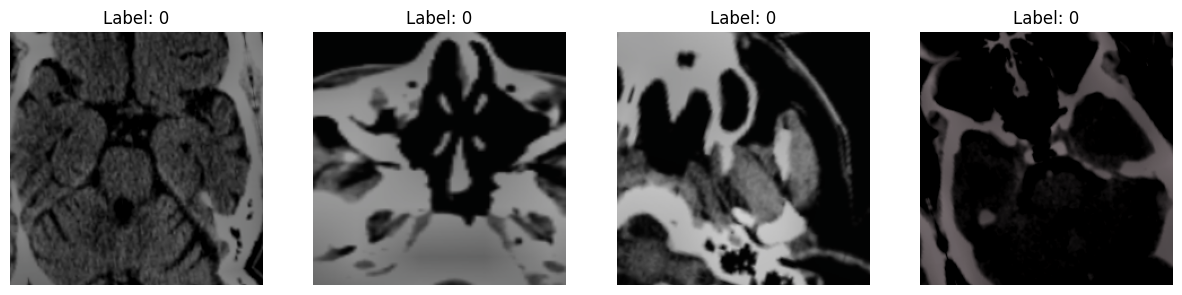

In [4]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

print("Training Images:")
visualize_random_images(dataloaders['train'])

# # Visualize random images from validation dataset
# print("Validation Images:")
# visualize_random_images(dataloaders['valid'])

# # Visualize random images from test dataset
# print("Testing Images:")
# visualize_random_images(dataloaders['test'])

In [5]:
from torchvision import models
from torch import nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load pretrained Densenet161 model
model = models.densenet161(pretrained=True)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False


cuda:0


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Truncate the model's features
features_children = list(model.features.children())
truncated_features_children = features_children[:-2]
truncated_features = nn.Sequential(*truncated_features_children).to(device)

# Determine the number of in_features for a possible fully connected layer
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = truncated_features(sample_input)
in_features = output.numel() // output.shape[0]
print("Number of in_features:", in_features)

Number of in_features: 51744


In [7]:
from collections import OrderedDict

# Replace the classifier (it will also be trainable by default)

classifier = nn.Linear(in_features, 2)  # Assuming you have 2 classes

dropout_probability = 0.2  # typically values are between 0.2 and 0.5

model = nn.Sequential(OrderedDict([
    ("features", truncated_features),
    ("flatten", nn.Flatten()),
    ("classifier", classifier)
]))

model.to(device)

Sequential(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)


In [8]:
# Load the saved model weights
model_path = 'best_model_weights.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode


Sequential(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)


In [9]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for inputs, classes in dataloaders['valid']:  # Use 'val' instead of 'valid'
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report = classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[9609  349]
 [1083 1322]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9958
           1       0.79      0.55      0.65      2405

    accuracy                           0.88     12363
   macro avg       0.84      0.76      0.79     12363
weighted avg       0.88      0.88      0.88     12363



In [10]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

def crop_brain(image, threshold=10):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold only
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the binary image
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    crop = image[y:y+h, x:x+w]
    
    return crop

# Define the custom Albumentations transform
class BrainCrop(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        
    def apply(self, image, **params):
        return crop_brain(image)

class CLAHE(A.ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def apply(self, image, **params):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(gray)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)
        return img_clahe

# Define the transform pipeline
primal_transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])


The predicted class for the image is: Hemorrhage
Probabilities for each class:
Normal: 32.66%
Hemorrhage: 67.34%


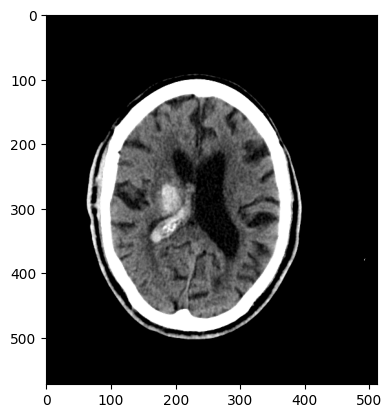

In [11]:
import torch.nn.functional as F

def predict_image_class_with_probabilities(model, image_path, transform, primal_transform):
    """
    Predict the class of an image and return the probabilities for each class.

    Parameters:
    - model: Trained PyTorch model.
    - image_path: Path to the image file (JPG or PNG).
    - transform: Image transformations to apply before prediction.

    Returns:
    - predicted_class: Predicted class label.
    - class_probabilities: Probabilities for each class.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)


    # Convert the PIL image to a numpy array
    image_np = np.array(image)

    image_np = primal_transform(image=image_np)["image"]

    
    # Apply the transformations using the named argument
    augmented = transform(image=image_np)
    image_tensor = augmented['image'].unsqueeze(0).to(device)  # The 'image' key contains the transformed image tensor
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)[0] * 100  # Convert to percentages
        _, predicted_idx = torch.max(output, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']  # Replace with your class names
    predicted_class = class_names[predicted_idx.item()]
    
    class_probabilities = {class_name: prob.item() for class_name, prob in zip(class_names, probabilities)}
    
    return predicted_class, class_probabilities


# Example usage
image_path = r"Test/slice_17.png"
image = Image.open(image_path)

predicted_class, class_probabilities = predict_image_class_with_probabilities(model, image_path, data_transforms['val'], primal_transform)
print(f"The predicted class for the image is: {predicted_class}")
print("Probabilities for each class:")
for class_name, prob in class_probabilities.items():
    print(f"{class_name}: {prob:.2f}%")
